# Setup

In [100]:
%matplotlib inline

import os
import random

from matplotlib import pyplot as plt

import seaborn as sns

import numpy as np
import pandas as pd
import cv2

In [101]:
# display images in grayscale
#matplotlib.rc('image', cmap='gray')

In [104]:
# get the list of filenames in a given directory

camera_view = 'KL11-E1DC'

availible_ids = [int(file.split('.')[0])
                 for file in os.listdir(f"./data/real/{camera_view}/") 
                 if file.endswith(".png")]

print(f'number of unique images: {len(availible_ids)}')
print(f'number of pairs: {len(availible_ids)*len(availible_ids)-1}')

number of unique images: 109
number of pairs: 11880


In [174]:
# some helper functions
def load_img(img_id):
    return cv2.imread(f'./data/{camera_view}/{img_id}.png', 
                      cv2.IMREAD_GRAYSCALE)


def plot_two(img_a, name_a, img_b, name_b):
    plt.figure(1, figsize=(13,13))
    
    plt.subplot(121)
    plt.title(name_a)
    plt.imshow(img_a)

    plt.subplot(122)
    plt.title(name_b)
    plt.imshow(img_b)
    
    plt.show()


def plot_three(imgs, names):
    # there is probably a better way...
    plt.figure(1, figsize=(17,10))
    
    for i in range(3):
        
        plt.subplot(131 + i)
        plt.title(names[i])
        plt.imshow(imgs[i])
    
    plt.show()

    

def map_2_params(img, _operation, x_params, x_param_name, y_params, y_param_name):
    """ 
    Makes a 2D grid of plots by applying the function '_operation' to 'img'
    accross the parameter space defined in the other arguments
    """
    # set up axes
    fig, axs = plt.subplots(nrows=len(x_params), 
                            ncols=len(y_params),
                            sharex='col', sharey='row',
                            figsize=(15,15.4))

    # loop through axes and make each plot
    for i, x_param in enumerate(x_params):        
        for j, y_param in enumerate(y_params):
            
            # plot image with these parameters
            axs[j,i].imshow(_operation(img, x_param, y_param))
            
            # decide whether or not to label axes
            if j == 0:
                axs[j,i].set_title(f'{x_param_name} = {x_param:.2f}')
            if i == 0:
                axs[j,i].set_ylabel((f'{y_param_name} = {y_param:.2f}'), fontsize=12)
            
            # tick hiding
            axs[j,i].tick_params(
                bottom=False,
                left=False,
                labelbottom=False,
                labelleft=False)
    
    # title
    fig.text(0.5, 0.92, f'Applying {_operation.__name__}()', ha='center', va='center', fontsize=14)
    
    # formatting
    fig.subplots_adjust(hspace=0.01, wspace=0.01)

# Preprocessing

We will see that good preprocessing is crucial for good feature detection. The preprocessing described here is all done manually, but we will eventually need to automate this step. There are certainly [more operations](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_table_of_contents_imgproc/py_table_of_contents_imgproc.html) we can try in this stage, but so far we have considered the following preprocessing operations:

- [Histogram equalisation](https://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html) - imroves contrast.
- [Bilateral Filter](https://docs.opencv.org/3.0-beta/modules/imgproc/doc/filtering.html) - denoising with edge preservation.
- [Nonlocal Means Filter](https://docs.opencv.org/3.0-beta/modules/photo/doc/denoising.html#fastnlmeansdenoising) - denoising.
- [Gaussian Subsampling](https://docs.opencv.org/3.0-beta/modules/imgproc/doc/filtering.html?highlight=pyrdown#pyrdown) - powerful denoising at the expense of resolution.

Here we just wrap some opencv functions for convenience

In [11]:
def correct_contrast(img, clip_limit=3, tile_size=7):
    
    # create the object
    clahe = cv2.createCLAHE(clipLimit=clip_limit, 
                            tileGridSize=(tile_size, tile_size))
    
    # apply equalisation
    return clahe.apply(img)

In [7]:
# clear
#img_id = 92182

# low contrast
img_id = 89065

# plasma blurry
#img_id = 89463

# plasma noisy
#img_id = 90469

# another one
#img_id = 90114

img_raw = cv2.imread(f'./data/real/KL11-E1DC/{img_id}.png', cv2.IMREAD_GRAYSCALE)

## [Gaussian Subsampling](https://docs.opencv.org/3.0-beta/modules/imgproc/doc/filtering.html?highlight=pyrdown#pyrdown)

Not much visible change to this low contrast, high noise image - except for a (unexplained) decrease in brightness.

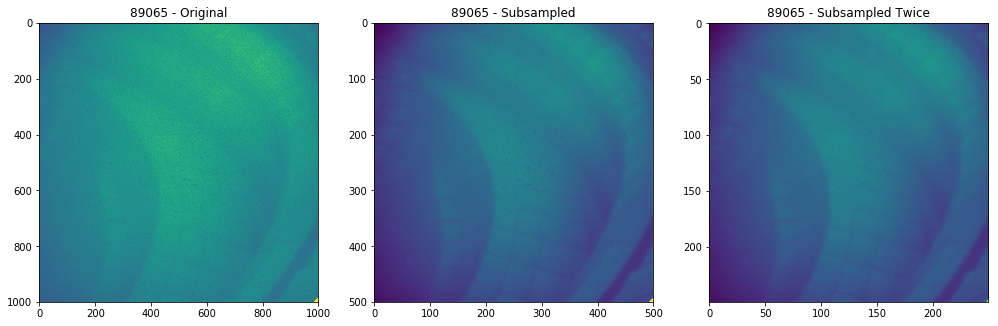

In [115]:
# downsample
downsampled = cv2.pyrDown(img_raw)
downsampled_twice = cv2.pyrDown(downsampled)

s = f'{img_id} - '
plot_three([img_raw, downsampled, downsampled_twice], 
           [s+'Original',s+'Subsampled',s+'Subsampled Twice'])

Let's look at the benefits we get in noise reduction after boosting the contrast. A big improvement! It's probably worth downasmpling every image we get. Note that downsampling twice could also be useful in some cases, though the additional benefit is not as clear. The 4x downsampled imgagees images are also starting to get quite small.

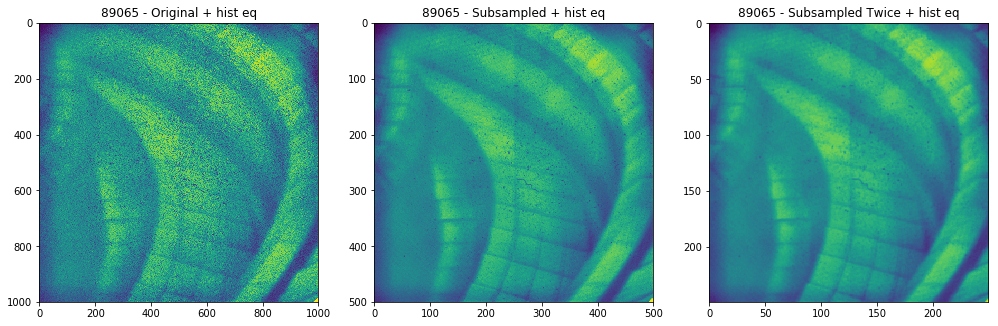

In [117]:
clip_limit = 6

plot_three([correct_contrast(img_raw, clip_limit), 
            correct_contrast(downsampled, clip_limit),
            correct_contrast(downsampled_twice, clip_limit)], 
           [s+'Original + hist eq',s+'Subsampled + hist eq',s+'Subsampled Twice + hist eq'])

## Constrast and Exposure Correction

It's clear that we need to pick the 'best' choice of parameters here - but what best means is not clear. While visual judgement does help to an extent, we don't know which image looks best to the feature detection algorithms.

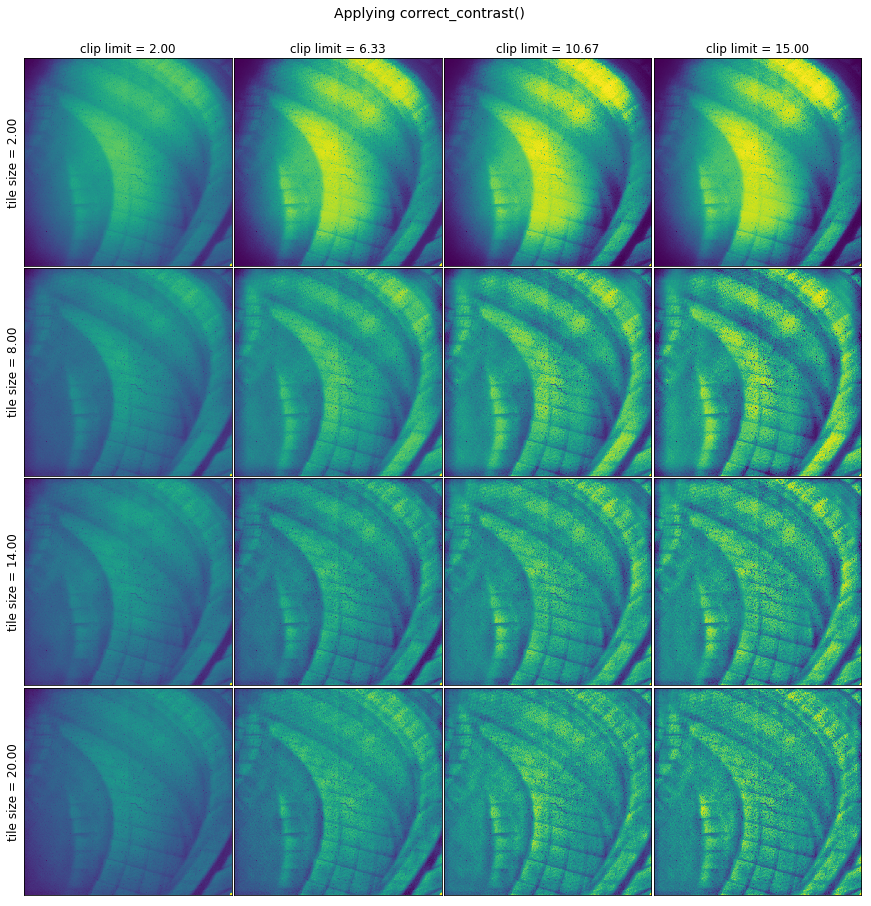

In [122]:
# set parameter space
clip_limits = np.linspace(2, 15, num=4)
tile_sizes = np.linspace(2, 20, num=4).astype(int)

# scan parameter space
map_2_params(downsampled, correct_contrast, 
             clip_limits, 'clip limit', 
             tile_sizes, 'tile size')

In [123]:
# subjectively make a choice of paramters to carry forward to the next step
contrast_downsampled = correct_contrast(downsampled, 7, 13)

## Denoising

There are two denoising algorithms that seem like good choices here.

- [Bilateral Filter](https://docs.opencv.org/3.0-beta/modules/imgproc/doc/filtering.html). There are also some nice lectures on it [here](http://people.csail.mit.edu/sparis/bf_course/), which suggest for example that it is possible to iterate a bilateral filter.
- [Nonlocal Means Filter](https://docs.opencv.org/3.0-beta/modules/photo/doc/denoising.html#fastnlmeansdenoising).

In [130]:
# wrap opencv functions so they are compatible with plots
def bilateral_filter(img, filter_size=5, sigma=70):
    
    # it's not clear exactly what the parameters represent in the docs...
    # (the sigmaSpace parameter appears to be superfluous)
    return cv2.bilateralFilter(img, d=filter_size,
                               sigmaColor=sigma,
                               sigmaSpace=sigma)

def nlm_filter(img, strength=2.5, window_size=6):
    return cv2.fastNlMeansDenoising(img, h=strength, searchWindowSize=window_size)

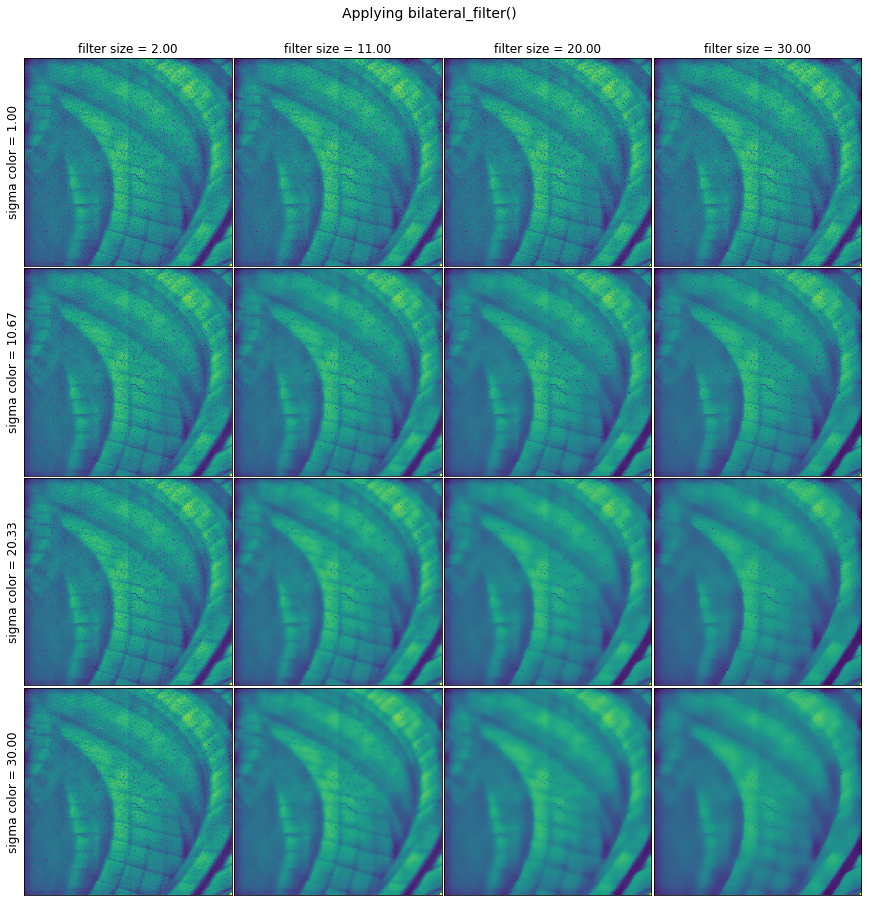

In [135]:
# set parameter space
filter_sizes = np.linspace(2, 30, num=4).astype(int)
sigma_colors = np.linspace(1, 30, num=4)

# scan parameter space
map_2_params(contrast_downsampled, bilateral_filter, 
             filter_sizes, 'filter size', 
             sigma_colors, 'sigma color')

In [140]:
contrast_ds_blf = bilateral_filter(contrast_downsampled, 10, 10)

Next nlm, which can do quite a nice job of removing the static lens dirt in some cases.

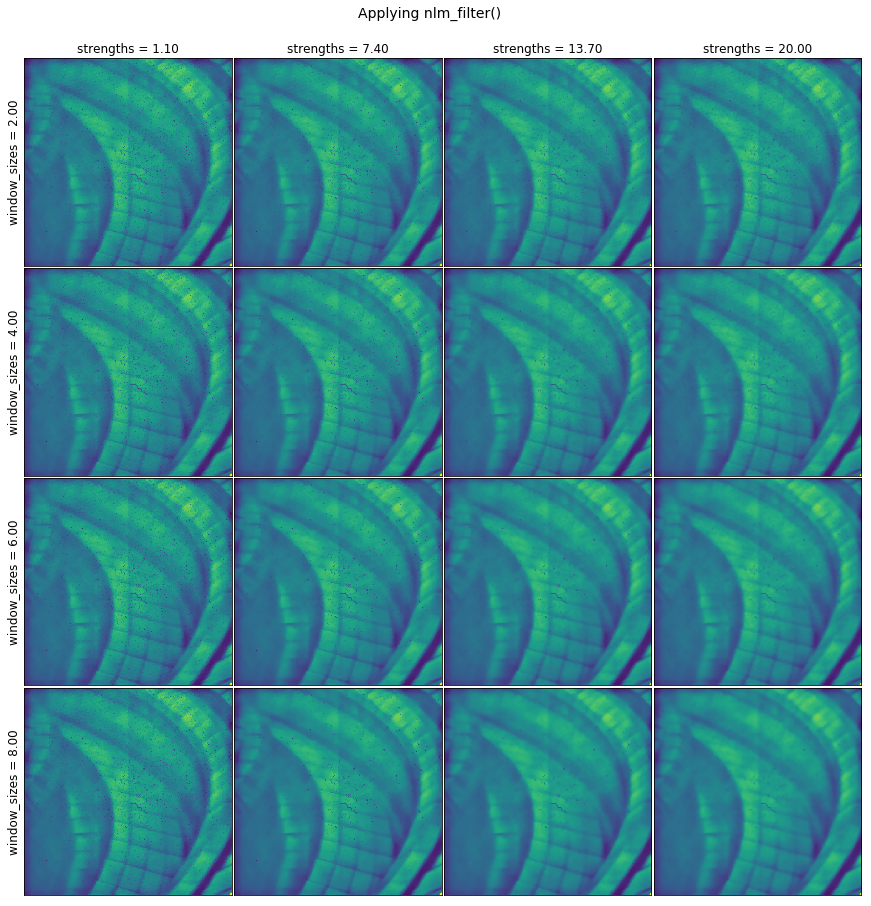

In [141]:
# set parameter space
strengths = np.linspace(1.1, 20, num=4)
window_sizes = range(2,10,2)

# scan parameter space
map_2_params(contrast_ds_blf, nlm_filter,
             strengths, 'strengths', 
             window_sizes, 'window_sizes')

In [158]:
contrast_ds_blf_nlm = nlm_filter(contrast_ds_blf, 2, 4)

# [Line Segment Detection](https://docs.opencv.org/3.0-beta/modules/imgproc/doc/feature_detection.html#createlinesegmentdetector)

It's meant to be relatively parameter free, but I have found that it is definitely worth optimisng the parameters.

In [159]:
def lsd(img, scale=None, sigma_scale=None, return_raw=False, return_lines=False):
    """wrapper for opencv's line segment detection functionality"""
    
    # if we don't specify parameters, leave the defaults
    if scale is None and sigma_scale is None:
        lsd = cv2.createLineSegmentDetector(_refine=cv2.LSD_REFINE_STD)
    
    # otherwise use our settings
    else:
        lsd = cv2.createLineSegmentDetector(_refine=cv2.LSD_REFINE_STD,
                                            _scale=scale,
                                            _sigma_scale=scale)
        
    # detect line segments
    _lines, width, prec, nfa = lsd.detect(img) 
    

    if return_lines:
        # just return a numpy array of line
        return _lines
    
    if return_raw:
        # draw lines on top of the raw image
        return lsd.drawSegments(downsampled, _lines)
    
    else:
        # draw lines on top of the preprocessed image
        return lsd.drawSegments(img, _lines)

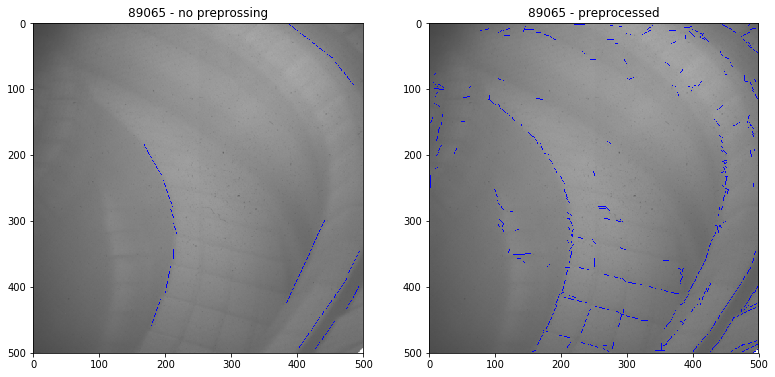

In [177]:
# detect lines
lines_1 = lsd(downsampled, 0.2, 0.7, return_raw=True)
lines_2 = lsd(contrast_ds_blf, return_raw=True)

plot_two(lines_1, f'{img_id} - no preprossing', 
         lines_2, f'{img_id} - preprocessed')

## How Preprocessing Affects LSD

In general we need to determine the best possible preprocessing for each image. This will mean we need to determine the optimal order of preprocessing steps, along with the parameters values to be applied at each step.

Below we load a random image, and apply default values of the three preprocessing steps in permuted orders to demonstrate that even the ordering of preprocessing steps has some impact.

In [168]:
random_id = random.choice(availible_ids)
img = cv2.imread(f'./data/real/KL11-E1DC/{random_id}.png', cv2.IMREAD_GRAYSCALE)
img = cv2.pyrDown(img)

pp_functions = [bilateral_filter, nlm_filter, correct_contrast]

def get_random_pp(img):
    random.shuffle(pp_functions)

    for pp in pp_functions:
        img = pp(img)
    
    ordering = [str(func).split(' ')[1] for func in pp_functions]
    
    return img, ordering

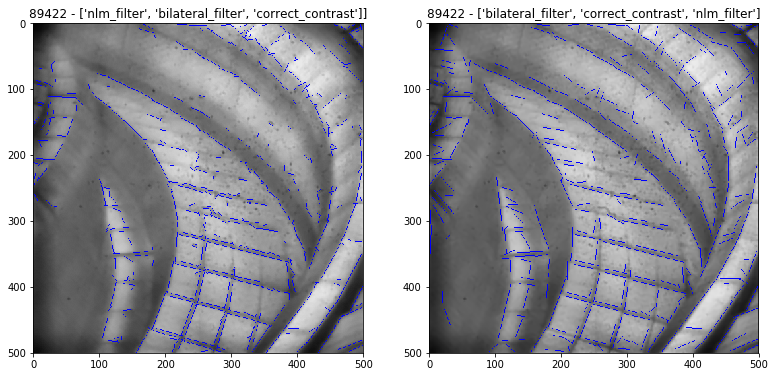

In [176]:
# process images in a random order
random_pp_1, order_1 = get_random_pp(img)
random_pp_2, order_2 = get_random_pp(img)

# detect lines
lines_1 = lsd(random_pp_1, 0.9, 0.1)
lines_2 = lsd(random_pp_2, 0.4, 0.9)

plot_two(lines_1, f'{random_id} - {order_1}]',
         lines_2, f'{random_id} - {order_2}')

## Optimising Preprocessing

A one-size-fits-all solution to the proproessing step wil give us results that are far from optimal. Below is an example of (right) a manually preprocesed image and (left) and image preprocessed using the (manually determined) optimal values for another images. This shows that different images have different optimal preprocessing. In order to optmise the preprocessing for each image we could either 

1. For each image, optimise its lsd using many different preprocessed version of the image as inputs. For this we would need a metric that scores the results of line segment detection, such that the left plot would score more highly than the right plot, below. Perhaps this could be done using the CAD model wireframe as a reference.

2. For a given batch of images, compute some set of descriptive properties (e.g. a contrast 'score') and and group images which are visually similar and would therefore need similar preprossing parmaters. When we want to detect lines on a new image, we calculate its properties and apply the corresponding preprocessing.

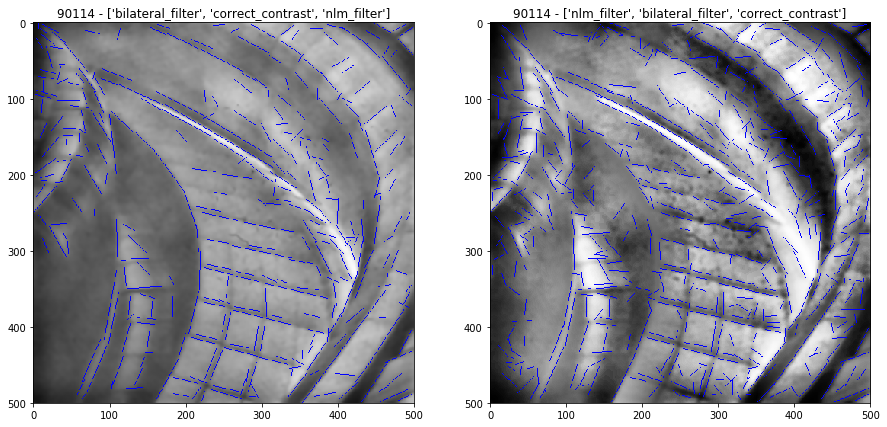

In [239]:
# example - DO NOT RUN

# Postprocessing Of Lines

Once we have our detected line segements there is a wealth of postprocessing options availible.

- Filtering out short lines
- Filtering out lines with 'bad' gradients
- Extend each line segement accross the entire image (or a subsection of it) and then only keep lines that overlap (i.e. are reinforced)
- [Here](https://stackoverflow.com/questions/45531074/how-to-merge-lines-after-houghlinesp) someone very successfully manages to group lines based on the assumption that lines will only be vertical or horizontal. Similar contraints may be possible for our purposes (i.e. the transverse lines are all at rougly the same gradient in the bottom third of the image)
- Use a package that is built for dealing with [shapes and geometry](https://shapely.readthedocs.io/en/latest/)
- A more advanced [clustering approach](https://stackoverflow.com/questions/46406870/python-clustering-hough-lines)
- A [Hough transform](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html)

In [183]:
_lines = np.squeeze(lsd(contrast_ds_blf, return_lines=True))

Lines are parameterised by (x1, y1, x2, y2).

In [184]:
_lines[0]

array([496.65787, 494.02887, 491.34702, 498.9105 ], dtype=float32)

## Manual Look

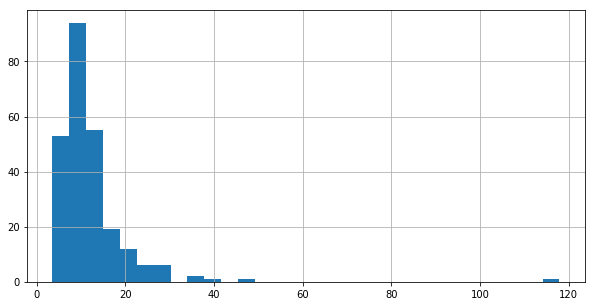

In [185]:
# put lines into a dataframe to be filtered
df = pd.DataFrame(_lines, columns=['x1', 'y1', 'x2', 'y2'])

# calculate length and gradients of lines
df['length'] = np.sqrt((df['x1'] - df['x2'])**2 + (df['y1'] - df['y2'])**2)
df['gradient'] = (df['y1'] - df['y2']) / (df['x1'] - df['x2'])

df['length'].hist(bins=30,  figsize=(10,5))

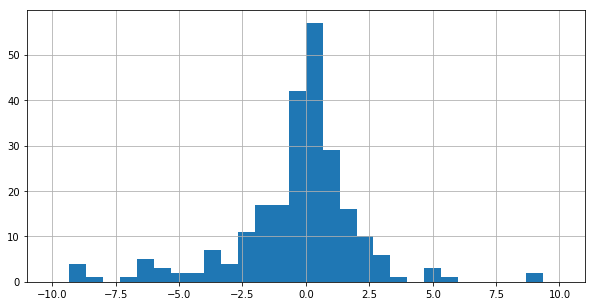

In [187]:
df['gradient'].hist(bins=30, range=(-10, 10), figsize=(10,5))

In [77]:
# filter small lines
df = df[df['length'] > 15]
filtered_lines = df[['x1', 'y1', 'x2', 'y2']].values

print(f'Filtered {len(_lines) - len(filtered_lines)} out of {len(_lines)} lines ')

Filtered 160 out of 269 lines 


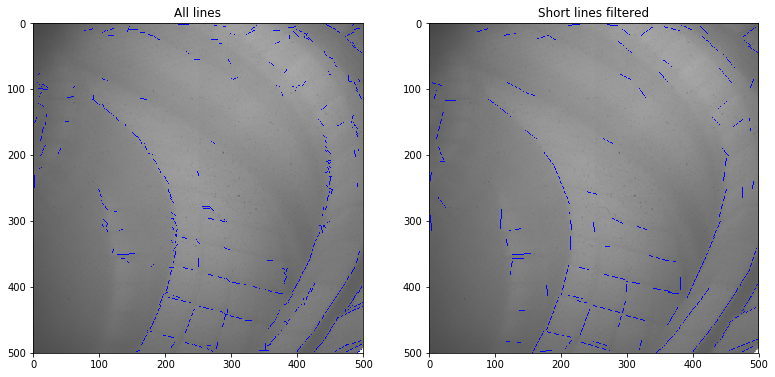

In [188]:
# draw line segments
lsd_ = cv2.createLineSegmentDetector(_refine=cv2.LSD_REFINE_STD)
img_with_lines = lsd_.drawSegments(downsampled, _lines)
img_with_filtered_lines = lsd_.drawSegments(downsampled, filtered_lines)

plot_two(img_with_lines, 'All lines', 
         img_with_filtered_lines, 'Short lines filtered')

## [Probabilistic Hough Transform](https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html#houghlinesp)

Algorithm for joining line segments based on a voting system in slope-intercept space.



In [198]:
# opencv compatibility
def get_lines(lines_in):
    if cv2.__version__ < '3.0':
        return lines_in[0]
    return [l[0] for l in lines_in]


# wrapper
def merge_lines(img, p1, p2):
    
    merged_lines = cv2.HoughLinesP(img, rho=p1, theta=2*np.pi/180, 
                             threshold=p2, minLineLength=20, 
                             maxLineGap=15)

    #img_with_merged_lines = np.copy(contrast_ds_blf_nlm)
    img_with_merged_lines = np.copy(img_with_filtered_lines)

    for line in get_lines(merged_lines):
        leftx, boty, rightx, topy = line
        cv2.line(img_with_merged_lines, (leftx, boty), (rightx,topy), (255, 255, 0), 2)
    
    return img_with_merged_lines

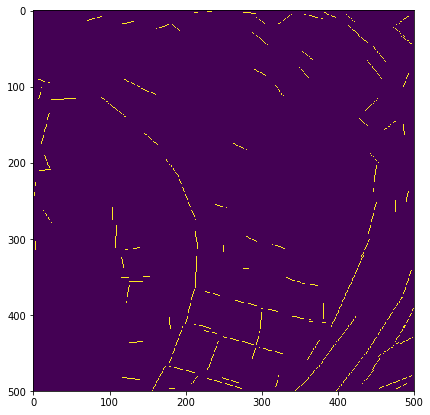

In [199]:
# get a binary image of the filtered line segments
just_filtered_lines = lsd_.drawSegments(np.zeros_like(img_with_filtered_lines), filtered_lines)
binary_lines = cv2.cvtColor(just_filtered_lines, cv2.COLOR_BGR2GRAY)

plt.figure(1, figsize=(7,7))
plt.imshow(binary_lines)
plt.show()

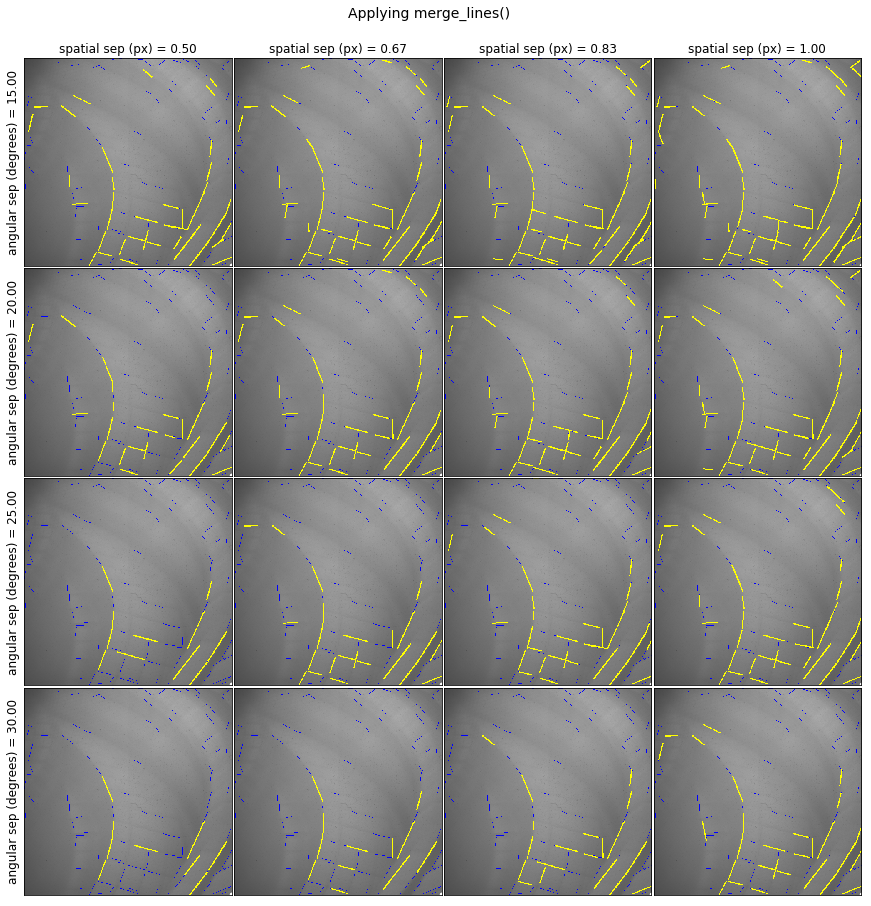

In [200]:
# set parameter space
rhos = np.linspace(0.5, 1, num=4)
thetas = np.linspace(15, 30, num=4).astype(int)

# scan parameter space
map_2_params(binary_lines, merge_lines, 
             rhos, 'spatial sep (px)', 
             thetas, 'angular sep (degrees)')

Some thoughts

- we will probably need a different approach to fitting the curved lines. As a first approximating we can assume that circles, when viewed in perspective, will become ellipses, which can be parameterised by three points [see here](http://www.math.utah.edu/~treiberg/Perspect/Perspect.htm#PerspProj)
- once we have intersections how do we know the actual correspondence of points? Maybe we have to hard code that found points will be close to their known position

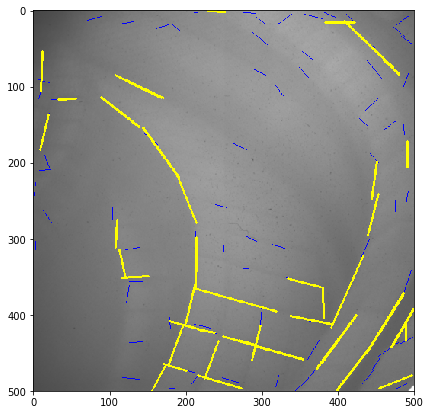

In [95]:
# DO NOT RUN
#plt.figure(1, figsize=(7,7))
#plt.imshow(merge_lines(binary_lines, p1=0.8, p2=25))
# here's one I made earlier with slightly better preprocessing

# Corner Detection

If results are quite crummy there are some ideas for improving them:

- Rerun corner detection with different paramters and only keep points that occur in each
- Use different corner detection algorithms [eg eigenvalue and harris](https://docs.opencv.org/3.0-beta/modules/imgproc/doc/feature_detection.html#cornersubpix) and then only keep points that are near each other.

We want to do this becuase it is excellent validation for the LSD. The idea is

1. Detect lines using LSD.
2. find the intesection of lines in order to define a set of points
3. check which of these correspond to points that are known to the corner detector.

There are also extra modules for corner detection in the `opencv contrib` module

In [225]:
def detect_corners(img, quality, block_size):

    img = np.copy(img)
    
    mask = np.zeros_like(contrast_ds_blf_nlm)

    mask[350:,:] = np.ones_like(mask[0,:])*255

    corners = cv2.goodFeaturesToTrack(img, maxCorners=20, 
                                      qualityLevel=quality, 
                                      minDistance=20,
                                      useHarrisDetector=False,
                                      blockSize=10,
                                      mask=mask)
    corners = np.int0(corners)

    for i in corners:
        x,y = i.ravel()
        cv2.circle(img,(x,y),2,0,-1)
        
    return img#, np.squeeze(corners)

Here we show weak dependence of the corner detection algorithm on its parameters.

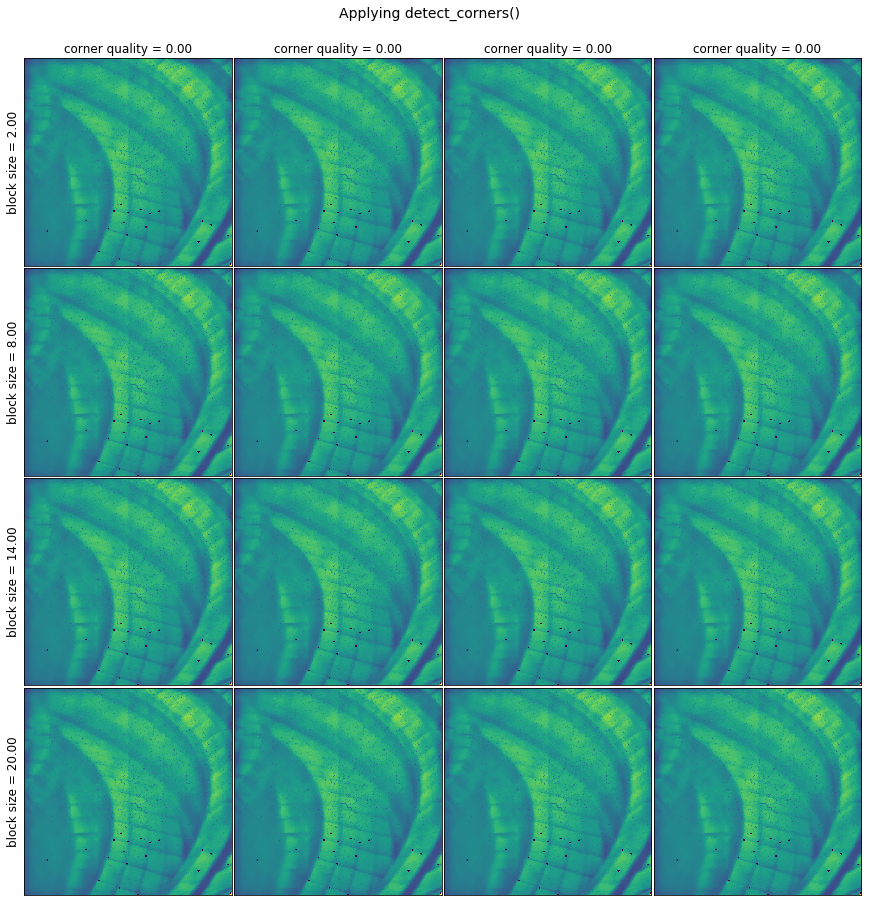

In [226]:
# set parameter space
qualities = np.linspace(0.00001, 0.001, num=4)
block_sizes = np.linspace(2, 20, num=4).astype(int)

# scan parameter space
map_2_params(contrast_ds_blf_nlm, detect_corners, 
             qualities, 'corner quality', 
             block_sizes, 'block size')

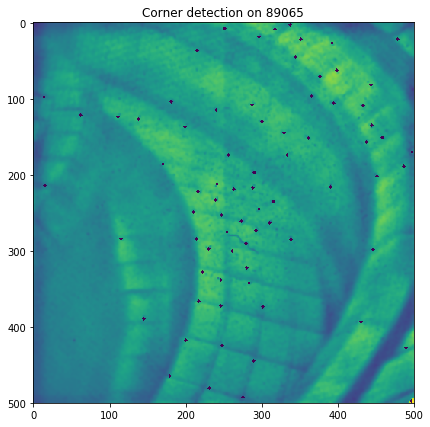

In [173]:
# one I made earlier showing that the grid of tiles at the bottom is well detected

The results of corner detection are very mixed from a first pass, but this might be okay. If we mask the image so that we only detect corners on, say, the lower third of the image (i.e. restricting ourselves to where the tiles are mostly clearly defined), we see that there are not too many erroneous corners, and the corners of the tiles often are captured correctly. We can use this to cross reference the results of the LSD intersections: this means that points we end up tracking are points which have both been

1. Reconstructed from detected lines using LSD.
2. Detected independently using corner detection.

Hopefully the noise in these two methods will cancel out and we will have more confidence that we are tracking useful points.

# Testing Other Views

## KL9

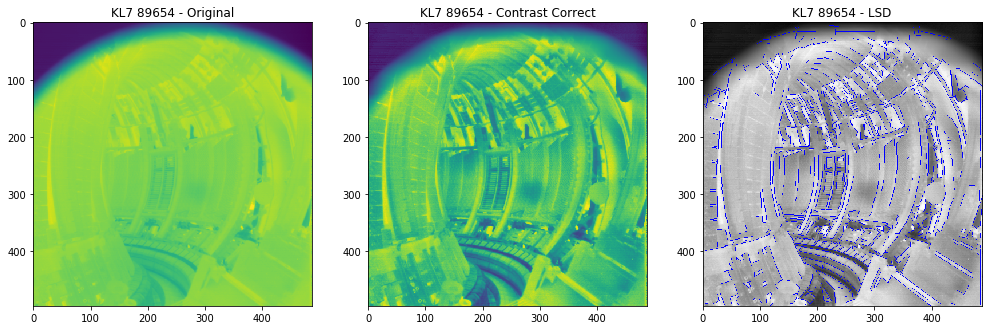

In [66]:
new_view = cv2.imread(f'./data/real/89654.png', cv2.IMREAD_GRAYSCALE)


# plot
plt.figure(1, figsize=(17,10))

plt.subplot(131)
plt.title('KL7 89654 - Original')
plt.imshow(new_view)

plt.subplot(132)
plt.title('KL7 89654 - Contrast Correct')
plt.imshow(correct_contrast(new_view, clip_limit=5))

plt.subplot(133)
plt.title('KL7 89654 - LSD')
plt.imshow(lsd(correct_contrast(new_view, clip_limit=5), scale=0.9, sigma_scale=0.1))

plt.show()

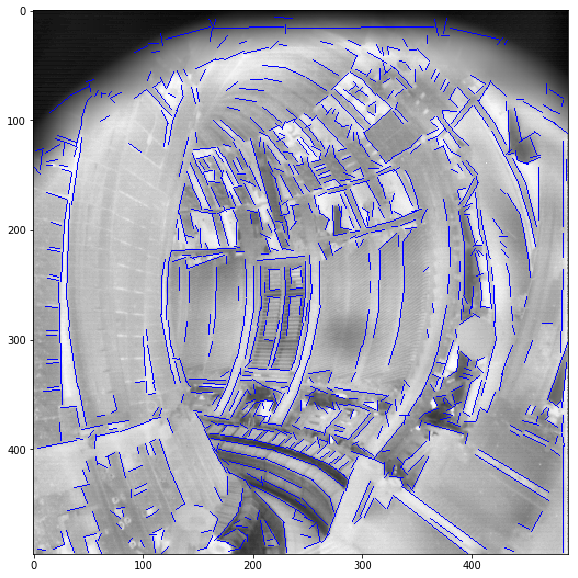

In [67]:
plt.figure(1, figsize=(17,10))
plt.imshow(lsd(correct_contrast(new_view, clip_limit=5), scale=0.9, sigma_scale=0.1))

## CIS-HM07

LSD fails quite predictably on the interferometer images. Maybe we can do something to remove the lines, using Fourier?

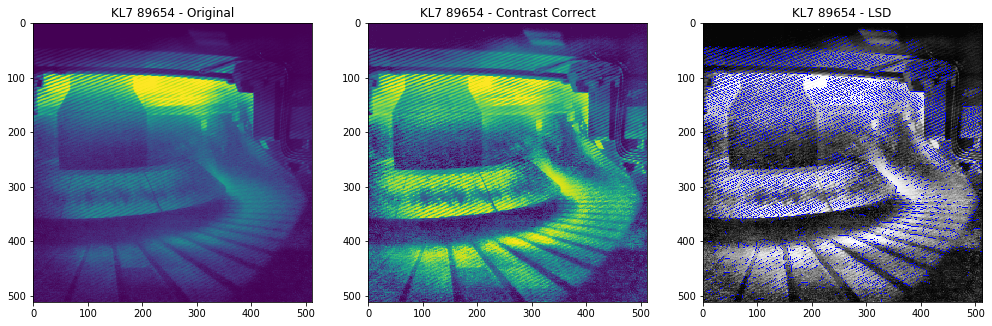

In [230]:
new_view = cv2.imread(f'./data/real/2013-07-18.tif', cv2.IMREAD_GRAYSCALE)

# plot
plt.figure(1, figsize=(17,10))

plt.subplot(131)
plt.title('KL7 89654 - Original')
plt.imshow(cv2.pyrDown(new_view))

plt.subplot(132)
plt.title('KL7 89654 - Contrast Correct')
plt.imshow(correct_contrast(cv2.pyrDown(new_view), clip_limit=5))

plt.subplot(133)
plt.title('KL7 89654 - LSD')
plt.imshow(lsd(correct_contrast(cv2.pyrDown(new_view), clip_limit=5), scale=0.9, sigma_scale=0.1))

plt.show()

# Next Week

1. Automated preprocessing.
2. Line segments to (hardcoded) identified points allowing for homographies.